# Predykcja przeżycia pasażera na pokładzie RMS Titanic 
## Projekt końcowy z przedmiotu <b>Podstawy uczenia maszynowego</b>
## Karol Nawrot, Michał Miękina


### Opis sytuacji 
RMS Titanic – brytyjski transatlantyk typu Olympic, brytyjskiego towarzystwa okrętowego White Star Line. W nocy z 14 na 15 kwietnia 1912 roku, podczas dziewiczego rejsu na trasie Southampton – Cherbourg – Queenstown – Nowy Jork, zderzył się z górą lodową i zatonął. Zginęło `1502` sprośród `2224` osób na pokładzie, co daje około `32%` szansy na przeżycie.

Niektóre grupy osób (dzieci, kobiety oraz klasa wyższa) miały większy wskaźnik przeżywalności niż pozostali. 
W danych widać też pewną zależność od narodowości (bycie Brytyjczykiem zmniejszało szanse przeżycia mężczyzn o 7% względem średniej, bycie Amerykaninem – zwiększało te szanse w stosunku do średniej o 8,5%). Niestety w naszym zestawie danych brakuje zmiennej określającej narodowość.

> Jednym z powodów takiej wysokiej śmiertelności był brak dostatecznej ilości łodzi ratunkowych, spowodowany przestarzałymi przepisami


Pierwszym etapem będzie wczytanie danych oraz omówienie argumentów.

Dane są w formacie .csv oraz są od razu podzielone na zbiór testowy oraz treningowy

In [2]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Opis kolumn
* **PassengerId** - unikalny identyfikator pasażera
* **Survived** - jest to etykieta która będziemy próbować przewidzieć, `0` oznacza `śmierć`, `1` - `przeżycie`
* **Pclass** - klasa biletu, możemy po tym mniej więcej określić klasę społeczną pasażerów, `1` oznacza `klasę wyższą`, `2` - `klasę średnią`, `3` - `klasę niższą`
* **Name** - Nazwa pasażera, jedyną użyteczną informacją dla nas może być tutaj tytuł danego pasażera, jeżeli takowy ma
* **Sex** - Płeć pasażera, mamy tutaj dwie kategorie - `male` oraz `female`
* **Age** - Wiek pasażera w latach, są to wartości z zakresu `0-80`, jeżeli wiek był mniejszy niż rok to jest ułamkiem dziesiętnym, jeżeli wiek danego pasażera był przybliżeniem to oznaczony jest końcówką .5
* **SibSp** - Ilość rodzeństwa (w tym mąż/żona) na pokładzie
* **Parch** - Ilość rodziców/dzieci na pokładzie
* **Ticket** - unikalny identyfikator biletu
* **Fare** - Opłata za bilet
* **Cabin** - Numer kabiny pasażera
* **Embarked** - Port w którym pasażer wszedł na pokład `C` = `Cherbourg`, `Q` = `Queenstown`, `S` = `Southampton`

 W przypadku kolumn **Survived**, **Sex** (dokładniej to skala dychotomiczna - tylko 2 wartości), **Embarked** mamy do czynienia z skalą nominalną (jedyną  relacją w tej skali jest równość)
 
 **Pclass** to dane ze skali porządkowej (elementy możememy ułożyć w pewną kolejność, ale nie znamy dokładnych odległości pomiędzy nimi)

 **Age**, **Fare** - Wartości ciągłe (skala ilorazowa - róznice jak i ilorazy mają swoją interpretacje)

  **SibSp**, **Parch** - Wartości dyskretne

### Analiza danych

In [4]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train_df.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Baxter, Mr. Quigg Edmond",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Mamy dużo brakujących informacji o wieku (`około 20%`) oraz o kabinie pasażera (`~80%`). Kilka wierszów nie posiada również portu rozpoczęcia rejsu. 
Brakujące wartości bedziemy musieli uzupełnić (`do napisania jak i co w koncu z tymi wartosciami`)

Sprawdzimy teraz kilka zależności widocznych w danych, konkretniej przeżywalność w zależności od płci, klasy biletu oraz wieku pasażera

         Survived
Pclass           
Class 1  0.629630
Class 2  0.472826
Class 3  0.242363


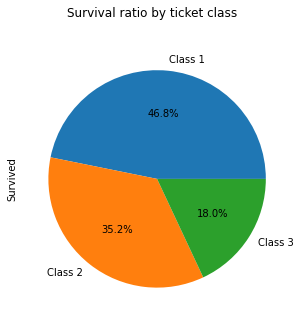

In [33]:


sex_to_survival=train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean()
sex_to_survival=sex_to_survival.rename(index={1:'Class 1',2:"Class 2",3:"Class 3"})
print(sex_to_survival)


plot=sex_to_survival.plot.pie(subplots=True, figsize=(5, 5),autopct='%1.1f%%',legend=False,title="Survival ratio by ticket class")